In [66]:
# GENERAL THINGS FOR COMPUTING AND PLOTTING
import pandas as pd
import numpy as np
import os, sys, time
from datetime import datetime
from datetime import timedelta
import scipy as sp

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")

# ibl specific things
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
from ibl_pipeline.analyses import behavior as behavioral_analyses

# set path for saving figures
figpath = 'figures' # put in the same folder, but add to .gitignore for now

In [67]:
########### SUBJECTS ########### 

subj = subject.Subject * subject.SubjectLab * subject.SubjectProject & 'lab_name="churchlandlab"' & 'subject_project = "churchland_learninglifespan"'

########### WEIGHINGS ########### 
weight_with_date = subj * action.Weighing.proj('weight', session_date='DATE(weighing_time)')
weight_date = (dj.U('subject_uuid', 'session_date') & weight_with_date) & 'session_date > "2020-02-22"'
#baseline_date = (dj.U('subject_uuid', 'session_date') & weight_with_date) & 'session_date < "2020-02-25"'

avg_weight_date = weight_date.aggr(weight_with_date, avg_weight='AVG(weight)') 
#avg_baseline_weight_date = baseline_date.aggr(weight_with_date, avg_weight = 'AVG(weight)')

b = subj * avg_weight_date 
#bb = subj * avg_baseline_weight_date
weight_df = pd.DataFrame(b.fetch(as_dict=True))
#baseline_df = pd.DataFrame(bb.fetch(as_dict=True))
weight_df.tail(n=5)

,subject_uuid,subject_project,session_date,subject_nickname,sex,subject_birth_date,ear_mark,subject_line,subject_source,protocol_number,subject_description,subject_ts,subject_strain,lab_name,subjectlab_ts,subjectproject_ts,avg_weight
342,f9009d7c-870e-44e6-b18d-32af0a2eb08d,churchland_learninglifespan,2020-03-05,CSHL074,M,2019-04-02,tail red,C57BL/6J,Jax,1,None,2020-02-20 04:55:05,C57BL/6J,churchlandlab,2020-05-06 13:43:06,2020-05-06 13:42:50,29.450001
343,f9009d7c-870e-44e6-b18d-32af0a2eb08d,churchland_learninglifespan,2020-03-13,CSHL074,M,2019-04-02,tail red,C57BL/6J,Jax,1,None,2020-02-20 04:55:05,C57BL/6J,churchlandlab,2020-05-06 13:43:06,2020-05-06 13:42:50,29.879999
344,f9009d7c-870e-44e6-b18d-32af0a2eb08d,churchland_learninglifespan,2020-02-25,CSHL074,M,2019-04-02,tail red,C57BL/6J,Jax,1,None,2020-02-20 04:55:05,C57BL/6J,churchlandlab,2020-05-06 13:43:06,2020-05-06 13:42:50,33.009998
345,f9009d7c-870e-44e6-b18d-32af0a2eb08d,churchland_learninglifespan,2020-03-06,CSHL074,M,2019-04-02,tail red,C57BL/6J,Jax,1,None,2020-02-20 04:55:05,C57BL/6J,churchlandlab,2020-05-06 13:43:06,2020-05-06 13:42:50,29.070000
346,f9009d7c-870e-44e6-b18d-32af0a2eb08d,churchland_learninglifespan,2020-03-14,CSHL074,M,2019-04-02,tail red,C57BL/6J,Jax,1,None,2020-02-20 04:55:05,C57BL/6J,churchlandlab,2020-05-06 13:43:06,2020-05-06 13:42:50,30.059999


In [68]:
########### WEIGHINGS NORMALIZATION and ########### 
########### CONVERSION OF SESSION DATES INTO SESSION NUMBERS ########### 

normalized_df = weight_df.copy()

#  how old are these mice on the first day of the intervention?
normalized_df['session_age'] = (datetime(2020, 3, 2).date() - normalized_df.subject_birth_date)
normalized_df['session_age'].describe()

########### ADD JAX DATA ########### 
jax_weights = pd.read_csv('data/jax_mouse_weights.csv')
jax_weights.head(n=3)

for weeknr, group in jax_weights.groupby(['Weeks']):
    
    if 44 <= group.Weeks.mean().item() <= 47:
        normalized_df = normalized_df.append({'subject_nickname':'Jax_male',
                              'sex':'M',
                              'session_date':datetime(2020, 3, 2).date() + 
                                              timedelta(days=(group.Weeks.mean().item() - 44) * 7),
                              'avg_weight':group.Males.mean().item()}, ignore_index=True)
        
        normalized_df = normalized_df.append({'subject_nickname':'Jax_female',
                              'sex':'F',
                              'session_date':datetime(2020, 3, 2).date() + 
                                              timedelta(days=(group.Weeks.mean().item() - 44) * 7),
                              'avg_weight':group.Females.mean().item()}, ignore_index=True)
normalized_df
# day 0 is the start of the experiment
normalized_df['session_day'] = (normalized_df['session_date'] - (datetime(2020, 3, 2)).date()).dt.days


In [73]:
normalized2 = pd.DataFrame([])
for index, sjdat in normalized_df.groupby(['subject_nickname']):
    sjdat['avg_weight'] = sjdat['avg_weight'] / sjdat.loc[sjdat.session_day < 1, 'avg_weight'].mean()
    normalized2 = normalized2.append(sjdat)

########### CONDITIONS ########### 
CA = 'Citric Acid'
Jax = 'Jax'

# condition_map = {'CSHL061':CA, 'CSHL062':CA, 'CSHL063':CA, 'CSHL064':CA, 
# 'CSHL065': CA, 'CSHL066':CA, 'CSHL067':CA, 'CSHL068':CA, 'CSHL069':CA,
# 'CSHL070':CA, 'CSHL071':CA, 'CSHL072':CA, 'CSHL073':CA, 
# 'CSHL074':CA, 'CSHL075':CA}

# remove mice that have dropped out
condition_map = {'CSHL063':CA,  'CSHL071':CA,
'CSHL065': CA, 'CSHL066':CA, 'CSHL067':CA, 'CSHL068':CA, 'CSHL069':CA,
'CSHL070':CA, 'CSHL071':CA, 'CSHL072':CA, 'CSHL073':CA, 
'CSHL074':CA, 'CSHL075':CA, 'Jax_male':Jax, 'Jax_female':Jax}

normalized2['condition'] = normalized2.subject_nickname.map(condition_map)

# choose only these animals
normalized2 = normalized2.loc[normalized2.subject_nickname.isin(condition_map.keys()), :]
# sorted(normalized2.subject_nickname.unique())
# sorted(normalized2.session_date.unique())
#normalized2

/anaconda3/envs/iblenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [74]:
# # compute age range
# normalized_df['session_age'] = (normalized_df.session_date - normalized_df.subject_birth_date)
# normalized_df.session_age.describe()

,protocol_number,avg_weight,session_day
count,240.0,244.000000,244.000000
mean,1.0,0.894621,5.147541
std,0.0,0.080425,6.981070
min,1.0,0.716134,-7.000000
25%,1.0,0.825746,0.000000
50%,1.0,0.886780,6.000000
75%,1.0,0.986811,11.000000
max,1.0,1.043427,16.000000


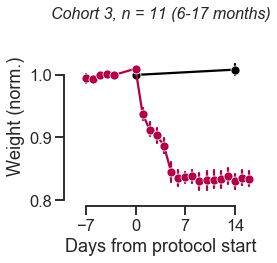

In [137]:
# REMOVE ONE OVERWEIGHT MOUSE
#normalized3 = normalized2[~normalized2['subject_nickname'].isin(['CSHL071'])]
f, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 4))
    
palette = sns.xkcd_palette(['black', 'raspberry'])
sns.lineplot(x="session_day", y="avg_weight", hue='condition', 
             err_style='bars', marker='o', hue_order=['Jax', 'Citric Acid'],
             ci=68, data=normalized3, ax=ax, legend=False, palette=palette)
ax.set_xlabel("Days from protocol start")    
ax.set_ylabel("Weight (norm.)")     
ax.set(ylim=[0.79, 1.08], yticks=[0.8, 0.9, 1], xticks=[-7, 0, 7, 14], xlim=[-10, 17])
#ax.text(-5, 0.85, 'n = %d'%normalized3.subject_nickname.nunique(), {'color':'k', 'fontsize':16})
ax.set_title('Cohort 3, n = %d (6-17 months)'%(normalized3.subject_nickname.nunique()-2), 
            fontsize=16, fontstyle='italic')
f.tight_layout()
sns.despine(trim=True)
#f.savefig(os.path.join(figpath, "citricacid_weights_churchlandlab.pdf"))
f.savefig(os.path.join(figpath, "suppfig2.png"), dpi=600)

normalized3.describe()

In [138]:
thirst = pd.read_csv('data/CSHL_CA_thirst.csv', parse_dates=['Date'])
thirst['date'] = thirst['Date'].dt.date
thirst['session_day'] = (thirst['date'] - (datetime(2020, 3, 2)).date()).dt.days

# unstack
thirst = pd.melt(thirst, id_vars=['session_day'], value_vars=['Avg_permouse_1', 'Av_permouse_2', 
                                                       'Avg_permouse_3'])
thirst


,session_day,variable,value
0,2,Avg_permouse_1,3.3525
1,3,Avg_permouse_1,2.5975
2,4,Avg_permouse_1,2.4650
3,5,Avg_permouse_1,5.4300
4,6,Avg_permouse_1,3.6625
5,7,Avg_permouse_1,2.5575
6,8,Avg_permouse_1,5.8150
7,9,Avg_permouse_1,2.6075
8,10,Avg_permouse_1,3.9625
9,11,Avg_permouse_1,2.6550


,protocol_number,avg_weight,session_day
count,240.0,244.000000,244.000000
mean,1.0,0.894621,5.147541
std,0.0,0.080425,6.981070
min,1.0,0.716134,-7.000000
25%,1.0,0.825746,0.000000
50%,1.0,0.886780,6.000000
75%,1.0,0.986811,11.000000
max,1.0,1.043427,16.000000


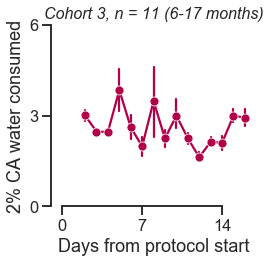

In [139]:


# REMOVE ONE OVERWEIGHT MOUSE
f, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 4))    
palette = sns.xkcd_palette(['black', 'raspberry'])
sns.lineplot(x="session_day", y="value", 
             err_style='bars', marker='o', 
             ci=68, data=thirst, ax=ax, legend=False, color=palette[1])
ax.set_xlabel("Days from protocol start")    
ax.set_ylabel("2% CA water consumed")     
ax.set(ylim=[0,6], yticks=[0, 3, 6], xticks=[-7, 0, 7, 14], xlim=[-1, 17])
#ax.text(-5, 0.85, 'n = %d'%normalized3.subject_nickname.nunique(), {'color':'k', 'fontsize':16})
ax.set_title('Cohort 3, n = %d (6-17 months)'%(normalized3.subject_nickname.nunique()-2), 
            fontsize=16, fontstyle='italic')
f.tight_layout()
sns.despine(trim=True)
#f.savefig(os.path.join(figpath, "citricacid_weights_churchlandlab.pdf"))
f.savefig(os.path.join(figpath, "suppfig2b.png"), dpi=600)

normalized3.describe()

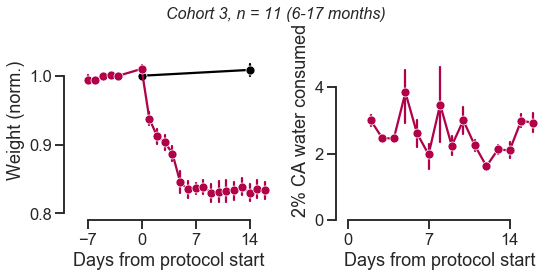

In [140]:
# REMOVE ONE OVERWEIGHT MOUSE
#normalized3 = normalized2[~normalized2['subject_nickname'].isin(['CSHL071'])]
f, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
    
palette = sns.xkcd_palette(['black', 'raspberry'])
sns.lineplot(x="session_day", y="avg_weight", hue='condition', 
             err_style='bars', marker='o', hue_order=['Jax', 'Citric Acid'],
             ci=68, data=normalized3, ax=ax[0], legend=False, palette=palette)
ax[0].set_xlabel("Days from protocol start")    
ax[0].set_ylabel("Weight (norm.)")     
ax[0].set(ylim=[0.79, 1.08], yticks=[0.8, 0.9, 1], xticks=[-7, 0, 7, 14], xlim=[-10, 17])
#ax.text(-5, 0.85, 'n = %d'%normalized3.subject_nickname.nunique(), {'color':'k', 'fontsize':16})
#ax[0].set_title()

sns.lineplot(x="session_day", y="value", 
             err_style='bars', marker='o', 
             ci=68, data=thirst, ax=ax[1], legend=False, color=palette[1])
ax[1].set_xlabel("Days from protocol start")    
ax[1].set_ylabel("2% CA water consumed")     
ax[1].set(ylim=[0,6], yticks=[0, 2, 4], xticks=[-7, 0, 7, 14], xlim=[-1, 17])
#ax.text(-5, 0.85, 'n = %d'%normalized3.subject_nickname.nunique(), {'color':'k', 'fontsize':16})
# ax=ax[1].set_title('Cohort 3, n = %d (6-17 months)'%(normalized3.subject_nickname.nunique()-2), 
#             fontsize=16, fontstyle='italic')

f.suptitle('Cohort 3, n = %d (6-17 months)'%(normalized3.subject_nickname.nunique()-2), 
            fontsize=16, fontstyle='italic')

f.tight_layout()
sns.despine(trim=True)
#f.savefig(os.path.join(figpath, "citricacid_weights_churchlandlab.pdf"))
f.savefig(os.path.join(figpath, "suppfig2_2panels.png"), dpi=600)
